In [6]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import tqdm

### TODO

Round to discrete sampling of (kappa, gamma, s). See, e.g., https://stats.stackexchange.com/a/360093 for why this is fine to do when sampling

In [7]:
def ln_like(theta, data, err):
    params = [v for k, v in theta.items()]
    return np.sum(-1/2 * ((params - data) / err)**2)

In [8]:
def ln_prior(theta, data, err):
    #first image is a minimum
    if (theta['kappa1'] < 0 or theta['kappa1'] > 1 or
        theta['s1'] < 0 or theta['s1'] > 1 or
        1 - theta['kappa1'] + theta['gamma1'] < 0 or
        1 - theta['kappa1'] - theta['gamma1'] < 0):
        return -np.inf
    
    #second image is a saddlepoint
    if (theta['kappa2'] < 0 or theta['kappa2'] > 1 or
        theta['s2'] < 0 or theta['s2'] > 1 or
        1 - theta['kappa2'] + theta['gamma2'] < 0 or
        1 - theta['kappa2'] - theta['gamma2'] > 0):
        return -np.inf
    
    #uniform priors
    return 0

In [9]:
def ln_prob(theta, data, err):
    return ln_prior(theta, data, err) + ln_like(theta, data, err)

In [10]:
param_names = ['kappa1', 'gamma1', 's1',
               'kappa2', 'gamma2', 's2',
               'm1', 'm2', 'v1']

data = np.array([0.49, 0.49, 0.2, 0.51, 0.51, 0.1, 0.9, 1.1, 0])
err = np.array([0.1, 0.05, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1, 1])

In [11]:
pos = np.array([0.4, 0.4, 0.1, 0.6, 0.5, 0.1, 1, 1, 0.5]) + np.random.normal(0, 0.01, size=(64,data.shape[0]))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, ln_prob, args=(data, err), 
    parameter_names=param_names
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:04<00:00, 1135.80it/s]


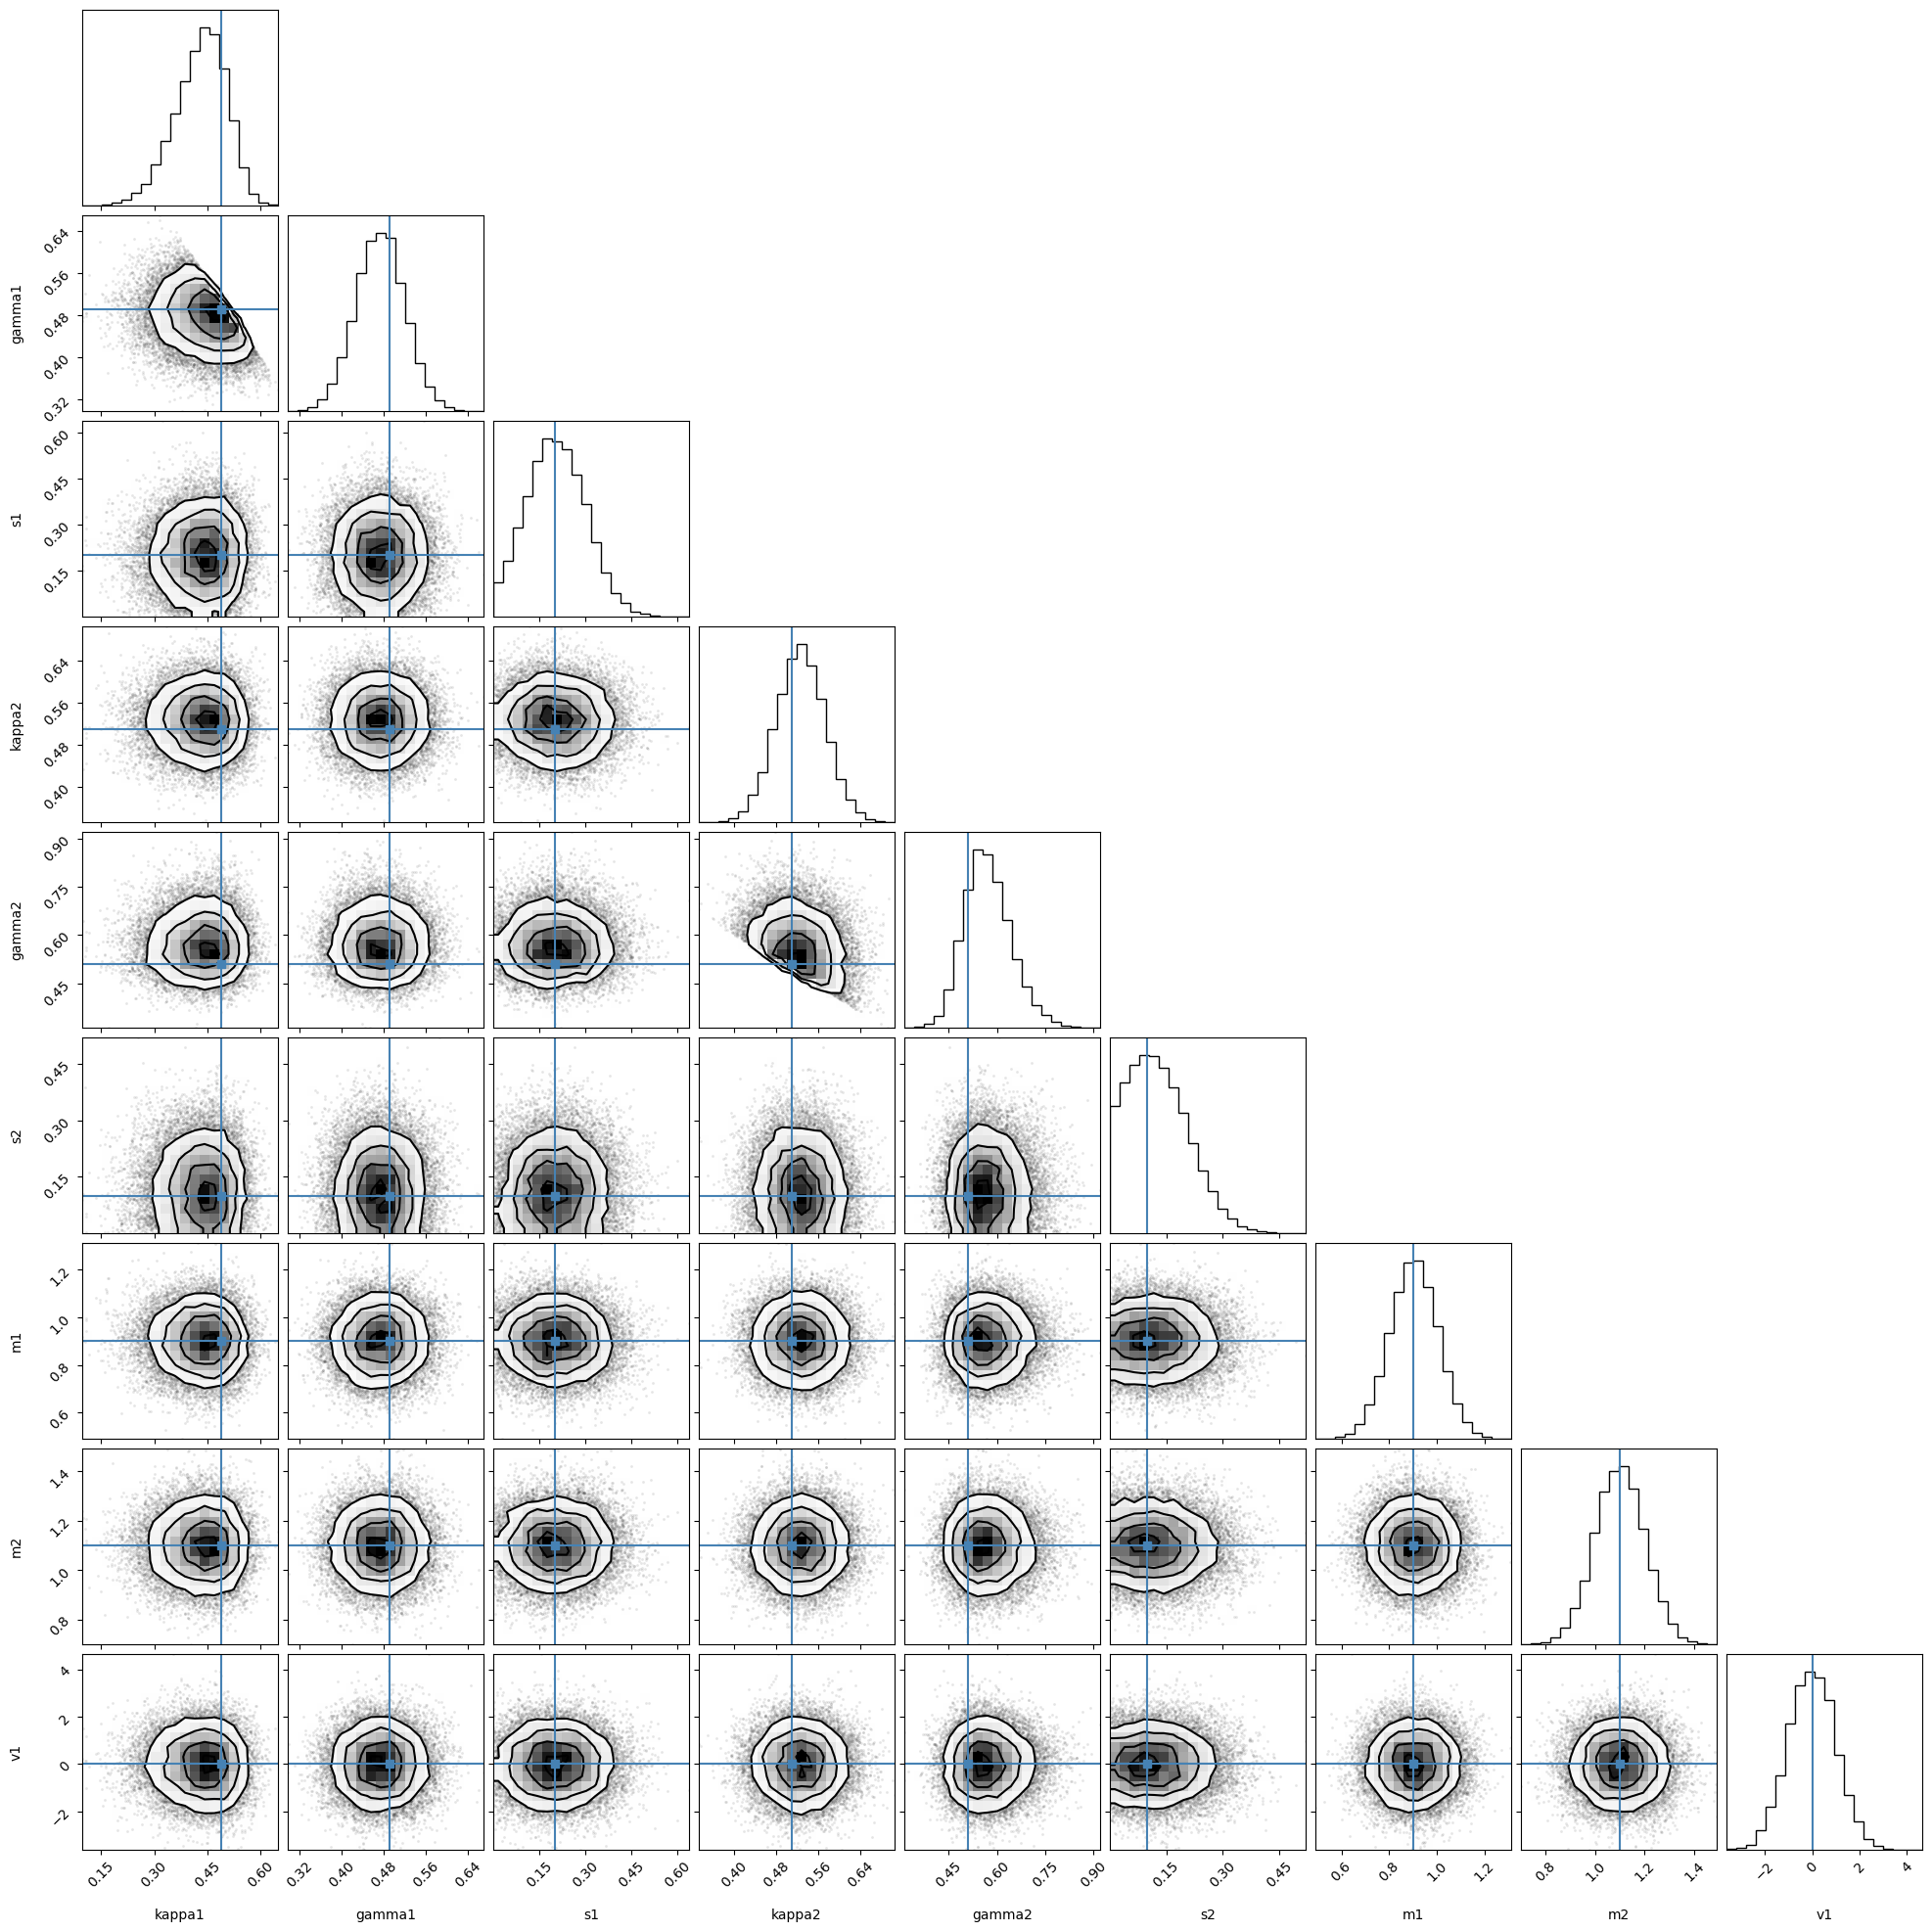

In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=param_names, truths=data
);